### Final ddrobot cells start from here

This notebook is for gridworld development



In [1]:
# class implementation of robo2links controller GUI
import numpy as np
import paho.mqtt.client as mqtt
import tkinter as tk
from tkinter import *
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from matplotlib.animation import FuncAnimation
import time

In [2]:
# use code from this link
# https://stackoverflow.com/questions/60413174/rotating-rectangles-around-point-with-matplotlib
class RotatingRectangle(Rectangle):
    def __init__(self, xy, width, height, rel_point_of_rot, **kwargs):
        super().__init__(xy, width, height, **kwargs)
        self.rel_point_of_rot = rel_point_of_rot
        self.xy_center = self.get_xy()
        self.set_angle(self.angle)

    def _apply_rotation(self):
        angle_rad = self.angle * np.pi / 180
        m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                            [np.sin(angle_rad), np.cos(angle_rad)]])
        shift = -m_trans @ self.rel_point_of_rot
        self.set_xy(self.xy_center + shift)

    def set_angle(self, angle):
        self.angle = angle
        self._apply_rotation()

    def set_rel_point_of_rot(self, rel_point_of_rot):
        self.rel_point_of_rot = rel_point_of_rot
        self._apply_rotation()

    def set_xy_center(self, xy):
        self.xy_center = xy
        self._apply_rotation()

In [5]:
# GridWorld6x6 class
# arguments :
# rmat : 6x6 matrix specifying rewards for each 36 states
# p : p(s'|s,a) probability of choosing action a. Default = 0.8
# gamma : discount factor. Default = 0.9
# eps : threshold to stop. Default = 0.001

class GridWorld6x6:
    def __init__(self,rmat= np.zeros((6,6)),mask = np.ones((6,6)),terminal = np.zeros((6,6)), p=0.8,gamma=0.9,eps=0.001):
        self.rmat = rmat
        self.mask = mask
        self.terminal = terminal
        self.vmat = np.zeros((6,6)) # value intialized to zero
        self.vmat_e = np.zeros((8,8))
        self.pimat = np.zeros((6,6)) #0=NORTH,1=EAST,2=SOUTH,3=WEST
        self.p = p # prob of intended policy
        self.pe = 0.5*(1-self.p) # prob that it wanders in undesired direction
        self.gamma = gamma
        self.eps = eps
        self.iter = 0
    # def setreward(self,row,col,val): # assign reward to a state (grid). First state is (0,0)
    #     self.rmat[row,col] = val
    # def setobstacle(self,row,col): # specify an obstacle grid
    #     self.mask[row,col] = 0
    # def setterminal(self,row,col): # specify a terminal grid
    #     self.terminal[row,col] = 1
    def setgrid(self, rmat, mask, terminal): # set all matrices
        self.rmat = rmat
        self.mask = mask
        self.terminal = terminal
    def setp(self,p):
        self.p = p
        self.pe = 0.5*(1-self.p)
    def setgamma(self,gamma):
        self.gamma = gamma
    def seteps(self, eps):
        self.eps = eps
    def getvmat(self):
        return np.round(self.vmat,2)
    def getpimat(self):
        return self.pimat
    def resetiter(self):
        self.iter = 0
    def getiter(self): # get iteration count
        return self.iter
    def reset(self):
        self.vmat = np.zeros((6,6)) # value intialized to zero
        self.vmat_e = np.zeros((8,8))
        self.pimat = np.zeros((6,6)) #0=NORTH,1=EAST,2=SOUTH,3=WEST
        self.iter = 0        


        
    def evalpi(self): # evaluate optimal policy
        # 0 = NORTH, 1 = EAST, 2 = SOUTH, 3 = WEST
        # augment edge of -inf to ease argmax() operation
        hedge = np.array([[-np.inf],[-np.inf],[-np.inf],[-np.inf],[-np.inf],[-np.inf]])
        self.vmat_e =  np.hstack((hedge,self.vmat,hedge))
        vedge = np.array([-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf])
        self.vmat_e = np.vstack((vedge,self.vmat_e,vedge))
        for i in range(6):
            for j in range(6):
                if not self.mask[i,j]: #  an obstacle grid
                    self.vmat_e[i+1,j+1] = -np.inf
        for i in range(1,7):
            for j in range(1,7):
                if self.mask[i-1,j-1]: # not an obstacle grid
                    v_north = self.vmat_e[i-1,j]
                    v_east = self.vmat_e[i,j+1]
                    v_south = self.vmat_e[i+1,j]
                    v_west = self.vmat_e[i,j-1]
                    a = np.argmax([v_north,v_east,v_south,v_west])
                    self.pimat[i-1,j-1] = a
                else: # obstacle
                    self.pimat[i-1,j-1] = -100
                if self.terminal[i-1,j-1]>0: # a positive terminal grid
                    self.pimat[i-1,j-1] = 10
                elif self.terminal[i-1,j-1]<0: # a negative terminal grid
                    self.pimat[i-1,j-1] = -10
        return self.pimat

    def solve(self):
        # self.iter = 0
        while self.iter<1000:
            self.step()
            # self.iter+=1
            #print(self.vmat)
            #print("Norm = "+str(np.linalg.norm(self.vmat - vmat1)))
            if np.linalg.norm(self.vmat - self.vmat1)<self.eps: 
                break
        print("Value iteration finishes at {} iterations".format(self.iter))
        return self.vmat                        
        
    def step(self):  # one step of dynamic programming of gridworld. Use in-place method
        # values correspoinding to x1 = NORTH, x2 = EAST, x3 = SOUTH, x4 = WEST
        # iter = 0
        # while iter<1000:
        self.vmat1 = self.vmat.copy() 
        self.iter += 1
        for i in range(6):
            for j in range(6):
                if self.mask[i,j] and not self.terminal[i,j]:  # not an obstacle grid nor a terminal grid
                    # case 1: NORTH obstacle only
                    if (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 2: NORTH and EAST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST                       
                    # case 3: NORTH and SOUTH obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 4: NORTH and WEST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 5: EAST obstacle only
                    elif (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 6: EAST and SOUTH obstacles
                    elif (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 7: EAST and WEST obstacles
                    elif (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 8: SOUTH obstacle only
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 9: SOUTH and WEST obstacles
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 10: WEST obstacle only
                    elif (j==0 or self.mask[i,j-1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 11: NORTH, EAST, SOUTH obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 12: NORTH, EAST, WEST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 13: NORTH, SOUTH, WEST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 14: EAST, SOUTH, WEST obstacles
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 15: NORTH,EAST, SOUTH, WEST obstacles. Absurd case, but need to have it
                    # to make things work properly
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and (i==0 or self.mask[i-1,j]==0): 
                        x1 = x2 = x3 = x4 = self.vmat[i,j] # every direccion bounces back
                    else: # no obstacle
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j+1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    self.vmat[i,j]=self.rmat[i,j]+self.gamma*max(x1,x2,x3,x4)
                
                if self.terminal[i,j]:  # terminal states require special handling
                    # print("i = {}, j = {} is a terminal state".format(i,j))
                    self.vmat[i,j] = self.rmat[i,j] # value of terminal state just equal to reward
                    # print("vmat[i,j] set to {}".format(self.vmat[i,j]))
        #print("Iteration "  + str(iter))
        # self.iter+=1
        return self.vmat
                        
                        


Connecting to mqtt broker
10.0
-10.0
-10.0
Value iteration finishes at 36 iterations
Cleaning up.. 


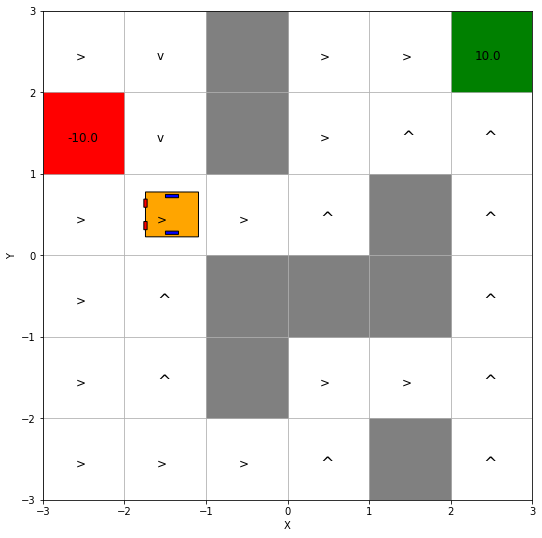

In [6]:
# GUI for differential-drive robot
class ddrController:

    def __init__(self, root):
        
        screen_width = 800
        screen_height = 800
        self.TFont0 = ("Consolas",12)
        self.TFont1 = ("Consolas",14)
        self.TFont2 = ("Consolas",16)
#         self.TFont1 = ("Calibri",14)
#         self.TFont2 = ("Calibri",16)
        

        self.rad2deg = 180/np.pi

        # --- flag variables --------------------
        self.online = True  # change to True to connect to NETPIE
        self.showrobot = False # flag to hide/show robot
        self.showtarget = False # show target as X sign
        self.pistart = False # start/stop moving along optimal policy
        
        root.title("Differential-Drive Robot Controller")
        root.protocol("WM_DELETE_WINDOW", self.on_close)
        root.geometry(str(screen_width)+'x'+str(screen_height))
        mainframe = ttk.Frame(root, padding="3 3 12 12")
        mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        root.columnconfigure(0, weight=1)
        root.rowconfigure(0, weight=1)
        cvrowspan = 15  # canvas row and column span.
        cvcolspan = 8  

        self.enable_txt = StringVar()
        self.xg_txt = StringVar()   # goal XY coordinate 
        self.yg_txt = StringVar()
        self.xt_txt = StringVar()  # XY coordinate of robot
        self.yt_txt = StringVar()
        self.theta_txt = StringVar() # orientation of robot
        self.gtrackmsg_txt = StringVar()
        self.gtrackmsg_txt.set("Ready")
        
        
        # send command to robot controller
        self.ddr_txt = StringVar()
        ddrcmd_entry = ttk.Entry(mainframe, textvariable=self.ddr_txt)
        ddrcmd_entry.grid(column=0, row=cvrowspan+5,sticky=(W, E))
        ttk.Button(mainframe, text="Send", command=self.send_ddr).grid(column=1, row=cvrowspan+5, sticky=W)

        
       
        #   ------ robot enable group.  ------------------------------
        self.pibutton_txt = StringVar()
        self.pibutton_txt.set("Start")
        self.selectstartmsg_txt = StringVar()
        self.selectstartmsg_txt.set("---")
        
        self.selectstart = BooleanVar()        
        enframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        enframe.grid(column=cvcolspan, row=0) #column=cvcolspan,row=0)        
        # self.feedback_txt.set("1")  
        ttk.Label(enframe, text="Robot          ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=0, sticky=(N,W))        
        self.disable_rb = (ttk.Radiobutton(enframe,text="Disable", variable=self.enable_txt,
                                     value="0",command=self.send_cmd_disable).
                                     grid(column=0, row=1, sticky=W))
        self.enable_rb = (ttk.Radiobutton(enframe, text="Enable", variable=self.enable_txt,
                                     value="1",command=self.send_cmd_enable).
                                     grid(column=0, row=2, sticky=W))
        ttk.Label(enframe, text="move along Pi*", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=3, sticky=(N,W))        
        ttk.Button(enframe, textvariable=self.pibutton_txt, command=self.pibutton_control).grid(column=1, 
                                     row=3, sticky=W) 
        self.pistarmsg_txt = StringVar()
        self.pistarmsg_txt.set("---")
        ttk.Label(enframe, textvariable=self.pistarmsg_txt, 
                  font=self.TFont1,foreground='orange').grid(column=0, row=4, sticky=W)        
        
        ttk.Checkbutton(enframe, text="select start grid",variable=self.selectstart,
                                        command=self.select_start_action).grid(column=0, 
                                                                row=5, sticky=W)
        ttk.Label(enframe, textvariable=self.selectstartmsg_txt, 
                  font=self.TFont1,foreground='olive').grid(column=0, row=6, sticky=W)    
        # adjust linear/angular velocity gains
        
        self.vk_txt = StringVar()
        self.wk_txt = StringVar()
        
        ttk.Label(enframe, text="Controller gains ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=7, sticky=(N,W))
        # linear velocity scale
        ttk.Label(enframe, text="V ",font=self.TFont1).grid(column=1, row=8, sticky=W)
        # note that tk scale is used instead of ttk here
        self.vgain_scale =(tk.Scale(enframe, orient=HORIZONTAL,length=150, from_=1.0, to=10.0,
                        resolution=1.0, troughcolor="blue",variable=self.vk_txt))        
        self.vgain_scale.grid(column=0, row=8)
        # this is how the slider is executed only on release!
        self.vgain_scale.bind("<ButtonRelease-1>", self.send_cmd_vk)  
        
        # angular velocity scale
        ttk.Label(enframe, text="W ",font=self.TFont1).grid(column=1, row=9, sticky=W)
        # note that tk scale is used instead of ttk here
        self.wgain_scale =(tk.Scale(enframe, orient=HORIZONTAL,length=150, from_=1.0, to=10.0,
                        resolution=1.0, troughcolor="green",variable=self.wk_txt))        
        self.wgain_scale.grid(column=0, row=9)
        # this is how the slider is executed only on release!
        self.wgain_scale.bind("<ButtonRelease-1>", self.send_cmd_wk)        

        
        #  -------- cartesian coordinate frame ------------------
        
        xyframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        xyframe.grid(column=cvcolspan,row=1)
        ttk.Label(xyframe, text="XY coordinates    ", 
                  font=self.TFont1,foreground='green').grid(column=0, row=0, sticky=W)
        ttk.Label(xyframe, text="X goal: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=1, sticky=W)
        ttk.Label(xyframe, textvariable=self.xg_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=1, sticky=W)
        ttk.Label(xyframe, text="Y goal: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=2, sticky=W)
        ttk.Label(xyframe, textvariable=self.yg_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=2, sticky=W)        
        ttk.Label(xyframe, textvariable=self.gtrackmsg_txt, 
                  font=self.TFont1,foreground='olive').grid(column=0, row=3, sticky=W)        
        
        ttk.Label(xyframe, text="X robot: ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=4, sticky=W)
        ttk.Label(xyframe, textvariable=self.xt_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=4, sticky=W)
        ttk.Label(xyframe, text="Y robot: ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=5, sticky=W)
        ttk.Label(xyframe, textvariable=self.yt_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=5, sticky=W)
        ttk.Label(xyframe, text="Theta : ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=6, sticky=W)
        
        ttk.Label(xyframe, textvariable=self.theta_txt, 
                  font=self.TFont1,foreground='orangered').grid(column=1, row=6, sticky=W)
        
        
        # enable function would do the job ?
#         ttk.Button(xyframe, text="Move", command=self.send_goal).grid(column=0, 
#                                                         row=6, sticky=W) 

        # ------- Plot control frame ------
        self.drawmode = BooleanVar()
#         self.showws = BooleanVar()
        self.showhist = BooleanVar() # history mode
        self.showpimat = BooleanVar()
        self.showvmat = BooleanVar()
        drawframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        drawframe.grid(column=cvcolspan,row=2)
        ttk.Label(drawframe, text="Plot control         ", 
                  font=self.TFont1,foreground='olive').grid(column=0, row=0, sticky=W)
        ttk.Checkbutton(drawframe, text="draw path",variable=self.drawmode).grid(column=0, 
                                                                row=1, sticky=W)
        ttk.Checkbutton(drawframe, text="history",variable=self.showhist).grid(column=0, 
                                                                row=2, sticky=W)
        
        ttk.Button(drawframe, text="Clear", command=self.clear_path).grid(column=0, 
                                     row=3, sticky=W) 
        ttk.Checkbutton(drawframe, text="show optimal policy",variable=self.showpimat).grid(column=0, 
                                                                row=4, sticky=W)
        ttk.Checkbutton(drawframe, text="show values",variable=self.showvmat).grid(column=0, 
                                                                row=5, sticky=W)

        # ----- gridworld variables --------------------
        self.rmat= np.zeros((6,6)) # reward definition matrix
        self.mask = np.ones((6,6)) # obstacle definition matrix
        self.terminal = np.zeros((6,6)) # terminal definition matrix

        self.gw = GridWorld6x6(rmat=self.rmat,mask=self.mask,terminal=self.terminal)
        # --- better define above value iteration frame ----
        #self.vmat = np.zeros((6,6))
        #self.pimat = np.zeros((6,6))
        
        self.rmat_tmp = self.rmat
        self.mask_tmp = self.mask
        self.terminal_tmp = self.terminal

        self.terminalval = 0.0  # value of terminal grid
        self.gridsaved = True  # flag wheter current grid definition is saved
        
        # --------  Define gridworld frame ----------------------
        self.definegw = BooleanVar()
        self.allgridval_txt = StringVar()
        self.allgridval_txt.set("0.0")
        self.terminalval_txt = StringVar()
        self.terminalval_txt.set("10.0")
        
        gwframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        gwframe.grid(column=cvcolspan,row=3)
        ttk.Checkbutton(gwframe, variable=self.definegw,command=self.define_grid_action).grid(column=0, 
                                                                row=0, sticky=E)
        ttk.Label(gwframe, text="Define grids", 
                  font=self.TFont1,foreground='olive').grid(column=1, row=0, sticky=W)
        ttk.Label(gwframe, text="Default grids : ", 
                  font=self.TFont0,foreground='magenta').grid(column=0, row=1, sticky=W)
        allgridval_entry = ttk.Entry(gwframe, textvariable=self.allgridval_txt)
        allgridval_entry.grid(column=1, row=1,sticky=(W, E))
        allgridval_entry.bind("<Return>", self.setallgrids)

        # text indicating grid selected
        self.gridselected_txt = StringVar()
        self.gridselected_txt.set("None")
        ttk.Label(gwframe, text="Grid selected : ", 
                  font=self.TFont0,foreground='green').grid(column=0, row=2, sticky=W)
        ttk.Label(gwframe, textvariable=self.gridselected_txt, 
                  font=self.TFont1,foreground='darkorange').grid(column=1, row=2, sticky=W)
        
        
        self.gridtype_txt=StringVar()
        self.gridtype_txt.set("0")
        
        (ttk.Radiobutton(gwframe,text="Specify terminal", variable=self.gridtype_txt,
                                     value="0",command=self.specify_terminal).
                                     grid(column=0, row=3, sticky=W))     
        terminalval_entry = ttk.Entry(gwframe, textvariable=self.terminalval_txt)
        terminalval_entry.grid(column=1, row=3,sticky=(W, E))
        terminalval_entry.bind("<Return>", self.setterminalval)
            
        (ttk.Radiobutton(gwframe,text="Specify obstacle", variable=self.gridtype_txt,
                                     value="1",command=self.specify_obstacle).
                                     grid(column=0, row=4, sticky=W))        
        self.gridsaved_txt=StringVar()
        self.gridsaved_txt.set("---")
        ttk.Label(gwframe, textvariable=self.gridsaved_txt, 
                  font=self.TFont1,foreground='darkorange').grid(column=0, row=5, sticky=W)

        
        ttk.Button(gwframe, text="Save", command=self.gw_save).grid(column=0, 
                                     row=6, sticky=W) 
        ttk.Button(gwframe, text="Clear", command=self.gw_clear).grid(column=1, 
                                     row=6, sticky=W) 
        ttk.Button(gwframe, text="Load Ex.", command=self.gw_example).grid(column=2, 
                                     row=6, sticky=W) 

        # ---- value iteration frame --------------
        self.viactive = BooleanVar()
        self.gamma = 0.9  # discount factor
        self.pa = 0.8 # probability of desired action
        self.iter = 0 
        self.vmat = np.zeros((6,6))
        self.pimat = 10*np.ones((6,6)) # doesn't show anything before solving
        self.pistar_valid = False  # wheter optimal policy exists

        viframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        viframe.grid(column=cvcolspan,row=4)        
        ttk.Checkbutton(viframe, variable=self.viactive).grid(column=0, 
                                                                row=0, sticky=E)
        ttk.Label(viframe, text="Value Iteration", 
                  font=self.TFont1,foreground='blue').grid(column=1, row=0, sticky=W) 
        # specify gamma value
        ttk.Label(viframe, text="Gamma (0-1) : ", 
                  font=self.TFont0,foreground='maroon').grid(column=0, row=1, sticky=W)
        self.gammaval_txt = StringVar()
        self.gammaval_txt.set(str(self.gamma))
        gammaval_entry = ttk.Entry(viframe, textvariable=self.gammaval_txt)
        gammaval_entry.grid(column=1, row=1,sticky=(W, E))
        gammaval_entry.bind("<Return>", self.setgammaval)

        
        # print gamma value
        # ttk.Label(viframe, textvariable=self.gammaval_txt, 
        #           font=self.TFont1,foreground='darkorange').grid(column=1, row=4, sticky=W)
        
        # specify Pa value
        ttk.Label(viframe, text="Pa (0-1) : ", 
                  font=self.TFont0,foreground='darkgreen').grid(column=0, row=2, sticky=W)
        self.paval_txt = StringVar()
        self.paval_txt.set(str(self.pa))
        
        paval_entry = ttk.Entry(viframe, textvariable=self.paval_txt)
        paval_entry.grid(column=1, row=2,sticky=(W, E))
        paval_entry.bind("<Return>", self.setpaval)

        ttk.Button(viframe, text="Step", command=self.vi_step).grid(column=0, 
                                     row=3, sticky=W) 
        ttk.Button(viframe, text="Solve", command=self.vi_solve).grid(column=1, 
                                     row=3, sticky=W) 
        ttk.Button(viframe, text="Reset", command=self.vi_reset).grid(column=2, 
                                     row=3, sticky=W) 
        
        self.iter_txt = StringVar()
        self.iter_txt.set("0")
        ttk.Label(viframe, text="Iteration : ", 
                  font=self.TFont0,foreground='green').grid(column=0, row=4, sticky=W)
        ttk.Label(viframe, textvariable=self.iter_txt, 
                  font=self.TFont1,foreground='darkorange').grid(column=1, row=4, sticky=W)
        
        
        # --- dew ninja logo frame        
        dnjframe = ttk.Frame(mainframe, padding = (2,2,2,2), relief="groove")
        dnjframe.grid(column=cvcolspan,row=5)        
        ttk.Label(dnjframe, text="dew.ninja 2024", font=self.TFont1,
                  foreground="red").grid(column=0,row=0,sticky=W)
        
        # ------ canvas for differential-drive robot display  ----------
        self.x_vec = []  # used for path draw
        self.y_vec = []
        # self.xg_vec = []
        # self.yg_vec = []
        self.fig, self.ax = plt.subplots(figsize=(9,9))
        cif = self.fig.canvas.mpl_connect('button_press_event',self.mouse_event) 

#         self.point_of_rotation = np.array([0, self.link_height/2])         
        # -----------------------------------------
        
#         self.time_step = 0.0
#         self.time_vec = []
#         self.y1_vec = []
#         self.y2_vec = []
#         self.y3_vec = []
       
#         self.fig, self.axes  = plt.subplots(2,1)
#         self.ax1, self.ax2 = self.fig.get_axes()
        self.canvas = FigureCanvasTkAgg(self.fig, master=mainframe)
        self.canvas.get_tk_widget().grid(row=0,column=0, rowspan=cvrowspan, columnspan=cvcolspan, sticky=W)
        self.an1 = FuncAnimation(self.fig, self.animate, interval=1000,cache_frame_data=False )
#      save_count=MAX_FRAMES or cache_frame_data=False
        

        for child in mainframe.winfo_children(): 
            child.grid_configure(padx=5, pady=5)
        
        self.Client_ID = "" # changed 
        self.User = ""
        self.Password = ""    
        self.broker = "broker.netpie.io"
        self.port = 1883     
        if self.online:
            self.mqtt_connect()
        
        self.enable = 0  # will be updated by ESP32
        self.mouse_x = 0.0  # mouse coordinate
        self.mouse_y = 0.0
        self.xg = 0.0  # goal coordinate.
        self.yg = 2.0
        self.xg_prev = 0.0  # used to prohibit sending same command
        self.yg_prev = 0.0
        self.xt = 0.0   # tool coordinate
        self.yt = 0.0
        self.theta = 0.0  # orientation

        # start pose for grid tracking
        self.xs = 0.0
        self.ys = 0.0
        self.thetas = 0.0
        
        self.heading = 0  # 0/1/2/3 -->NORTH/EAST/SOUTH/WEST
        self.heading_txt = ['North','East','South','West']
        self.heading_rad = [np.pi/2,0.0,-np.pi/2,np.pi]
        self.robot_row = 0  # grid row & column that contains robot
        self.robot_col = 0
        
        # robot parameters
        self.LEFT_WHEEL = 0
        self.RIGHT_WHEEL = 1
        self.WHEEL_RADIUS = 0.08
        self.WHEEL_DIAMETER = 2*self.WHEEL_RADIUS
        self.WHEEL_THICKNESS = 0.04
        self.WHEEL_SEPARATION = 0.45
        self.BASE_LENGTH = 0.65
        self.BASE_WIDTH = 0.55
        self.EYE_THICKNESS = 0.04
        self.EYE_DIAMETER = 0.1
        
        # ------------ gridworld parameters -------------------
        self.pi_offset = 0.1  # offset for displaying policy
        self.vc_offset_x = 0.2 # show value at center of grid
        self.vc_offset_y = 0.1
        self.vl_offset_x = 0.2 # show value at center of grid
        self.vl_offset_y = 0.4
        
        self.grid_bounds_x = np.array([-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0])
        self.grid_bounds_y = np.array([3.0,2.0,1.0,0.0,-1.0,-2.0,-3.0])
        
        self.grid_center_x = np.array([-2.5,-1.5,-0.5,0.5,1.5,2.5])
        self.grid_center_y = np.array([2.5,1.5,0.5,-0.5,-1.5,-2.5])
        self.grid_pi_x = self.grid_center_x - self.pi_offset
        self.grid_pi_y = self.grid_center_y - self.pi_offset
        self.grid_vc_x = self.grid_center_x - self.vc_offset_x
        self.grid_vc_y = self.grid_center_y - self.vc_offset_y
        self.grid_vl_x = self.grid_center_x - self.vl_offset_x
        self.grid_vl_y = self.grid_center_y - self.vl_offset_y

        self.grid_width = 1.0
        self.grid_height = 1.0

        self.grid_col = 0  # row and column of selected grid
        self.grid_row = 0

        
        
#         self.xg_txt.set(str(round(self.xg,2)))
#         self.yg_txt.set(str(round(self.yg,2)))
        

    def mqtt_connect(self):
        print("Connecting to mqtt broker")
        try:
            self.client = mqtt.Client(client_id=self.Client_ID,
                         transport='tcp',
                         protocol=mqtt.MQTTv311,
                         clean_session=True)
            self.client.username_pw_set(self.User,self.Password)
            self.client.connect(self.broker, port=self.port, keepalive=60)
            self.client.subscribe("@msg/update")
            #self.client.subscribe("@msg/shadowdata")
            self.client.on_message = self.on_message
            self.client.loop_start()
        except:
            print("Problem connecting to mqtt broker")

    def on_message(self,client, userdata, message):
        self.rcvd_msg = str(message.payload.decode("utf-8"))
        self.rcvd_topic = message.topic
#         #print("message received ", self.rcvd_msg)
#         #print("message topic=",message.topic)

        if self.rcvd_topic == "@msg/update":
            parm_data = self.rcvd_msg.split(',')
            # strings for GUI update
            self.enable_txt.set(parm_data[3])
            self.xt_txt.set(parm_data[0])
            self.yt_txt.set(parm_data[1])
            self.theta_txt.set(parm_data[2])
            
            # update parameters
            self.enable = int(parm_data[3])
            self.gtrackmode = int(parm_data[4])
            if self.gtrackmode:
                self.gtrackmsg_txt.set("Tracking grid")
            else:
                self.gtrackmsg_txt.set("Ready")
                
            self.xt = float(parm_data[0])
            self.yt = float(parm_data[1])
            self.theta = float(parm_data[2])

       
            
    def animate(self,i):
        if not self.showhist.get():  # delete previous plot or not
            self.ax.cla()
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-3.0,3.0)
        self.ax.set_ylim(-3.0,3.0)
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        self.ax.grid(True)

        # ----- show current definition of gridworld ------------------
        for i in range(6):
            for j in range(6):
                llx = self.grid_center_x[j]-0.5*self.grid_width
                lly = self.grid_center_y[i]-0.5*self.grid_height
                if not self.mask_tmp[i,j]:
                    #print("Plot obstacle at {},{}".format(llx,lly))
                    self.ax.add_patch(Rectangle((llx,lly),self.grid_width,
                                                self.grid_height,color='gray'))
                if self.terminal_tmp[i,j]:
                    if self.rmat_tmp[i,j] > 0: # any reward
                        self.ax.add_patch(Rectangle((llx,lly),self.grid_width,
                                                    self.grid_height,color='green'))
                        self.ax.text(self.grid_vc_x[j],self.grid_vc_y[i],
                                     str(self.rmat_tmp[i,j]), fontsize = 12)
                    if self.rmat_tmp[i,j] > 50: # gold reward 
                        self.ax.add_patch(Rectangle((llx,lly),self.grid_width,
                                                    self.grid_height,color='gold'))
                        self.ax.text(self.grid_vc_x[j],self.grid_vc_y[i],
                                     str(self.rmat_tmp[i,j]), fontsize = 12)
                    if self.rmat_tmp[i,j] < 0: # bad reward
                        self.ax.add_patch(Rectangle((llx,lly),self.grid_width,
                                               self.grid_height,color='red'))
                        self.ax.text(self.grid_vc_x[j],self.grid_vc_y[i],
                                str(self.rmat_tmp[i,j]), fontsize = 12)
                if self.showpimat.get():
                    if self.pimat[i,j] == 0: # NORTH
                        self.ax.text(self.grid_pi_x[j],self.grid_pi_y[i],'^', fontsize = 16)
                    elif self.pimat[i,j] == 1: # EAST
                        self.ax.text(self.grid_pi_x[j],self.grid_pi_y[i],'>', fontsize = 12)
                    elif self.pimat[i,j] == 2: # SOUTH
                        self.ax.text(self.grid_pi_x[j],self.grid_pi_y[i],'v', fontsize = 12)
                    elif self.pimat[i,j] == 3: # WEST
                        self.ax.text(self.grid_pi_x[j],self.grid_pi_y[i],'<', fontsize = 12)
                    if self.showvmat.get() and self.mask_tmp[i,j] and not self.terminal_tmp[i,j]: 
                        # show vmat at bottom of grid except terminal grid
                        self.ax.text(self.grid_vl_x[j],self.grid_vl_y[i],str(round(self.vmat[i,j],2)),fontsize=12)
                else:
                    if self.showvmat.get() and self.mask_tmp[i,j]: # if pi not shown, show vmat at center
                            self.ax.text(self.grid_vc_x[j],self.grid_vc_y[i],str(round(self.vmat[i,j],2)),fontsize=12)


        #  -------- show robot image on grid ---------------
        if self.showrobot:  
    #         self.ax.plot(0, 0,  color='orange', marker='o', markersize=30)
            base_height = self.BASE_WIDTH
            base_width = self.BASE_LENGTH

            if self.pistart:
                self.follow_pistar() # move along optimal policy

            
            # find 5 points of robot related to theta
            # center, left-right wheels, left-right eyes (front size)
            x_center = self.xt
            y_center = self.yt
            theta = self.theta*self.rad2deg
    #         print("{},{},{}".format(x_center,y_center,theta))
    
    
            robot_point_of_rotation = np.array([base_width/2, base_height/2]) # mid point
    
            robot_base = RotatingRectangle((x_center,y_center), width=base_width, height=base_height, 
                                        rel_point_of_rot=robot_point_of_rotation,
                                        angle=theta, edgecolor='black', facecolor='orange')
            self.ax.add_patch(robot_base)
    
            # left wheel 
            x_lw = 0
            y_lw = self.WHEEL_SEPARATION/2
    
            # right wheel
            x_rw = 0
            y_rw = - self.WHEEL_SEPARATION/2
    
            # left eye
            x_le = self.BASE_LENGTH/2
            y_le = self.BASE_WIDTH/4
    
            # right eye
            x_re = self.BASE_LENGTH/2
            y_re = -self.BASE_WIDTH/4
    
            # rotate these points relative to theta
            xy_lw = self.rotate_points(theta,(x_lw,y_lw),(x_center,y_center))
            xy_rw = self.rotate_points(theta,(x_rw,y_rw),(x_center,y_center))
            xy_le = self.rotate_points(theta,(x_le,y_le),(x_center,y_center))
            xy_re = self.rotate_points(theta,(x_re,y_re),(x_center,y_center))
            # xy_lw = (x_lw,y_lw)
            # xy_rw = (x_rw,y_rw)
            # xy_le = (x_le,y_le)
            # xy_re = (x_re,y_re)
            wheel_height = self.WHEEL_THICKNESS
            wheel_width = self.WHEEL_DIAMETER
    
            # left wheel
            lw_point_of_rotation = np.array([wheel_width/2, wheel_height/2]) # mid point of left wheel
            robot_lw = RotatingRectangle(xy_lw, width=wheel_width, height=wheel_height, 
                                        rel_point_of_rot=lw_point_of_rotation,
                                        angle=theta, edgecolor='black', facecolor='blue')
            self.ax.add_patch(robot_lw)
    
            # right wheel
            rw_point_of_rotation = np.array([wheel_width/2, wheel_height/2]) # mid point of right wheel
            robot_rw = RotatingRectangle(xy_rw, width=wheel_width, height=wheel_height, 
                                        rel_point_of_rot=rw_point_of_rotation,
                                        angle=theta, edgecolor='black', facecolor='blue')
            self.ax.add_patch(robot_rw)
    
            # ---- add eyes ---------
            eye_height = self.EYE_DIAMETER
            eye_width = self.EYE_THICKNESS
    
            # left eye
            le_point_of_rotation = np.array([eye_width/2, eye_height/2]) # mid point of left eye
            robot_le = RotatingRectangle(xy_le, width=eye_width, height=eye_height, 
                                        rel_point_of_rot=le_point_of_rotation,
                                        angle=theta, edgecolor='black', facecolor='red')
            self.ax.add_patch(robot_le)
    
            # right eye
            re_point_of_rotation = np.array([eye_width/2, eye_height/2]) # mid point of left eye
            robot_re = RotatingRectangle(xy_re, width=eye_width, height=eye_height, 
                                        rel_point_of_rot=re_point_of_rotation,
                                        angle=theta, edgecolor='black', facecolor='red')
            self.ax.add_patch(robot_re)
        # -------------------- end of if showrobot: -----------------------

        if self.showtarget:
            self.ax.plot(self.xg, self.yg,  color='maroon', marker='+', markersize=15) # target position

#         if self.showws.get(): # draw workspace
#             robo_ws = plt.Circle((0.0,0.0),2, color='m',fill=False)
#             self.ax.add_patch(robo_ws)
            
        if self.drawmode.get():   # draw path
            self.x_vec.append(self.xt)
            self.y_vec.append(self.yt)
            self.ax.plot(self.x_vec,self.y_vec,'blue')
            # self.ax.plot(self.xg_vec,self.yg_vec,'red',marker='X',linestyle='None',markersize=15)
#        print("Animating")



    def send_ddr(self, *args):  # changed to send arbitrary command
        cmd_txt = self.ddr_txt.get()
        if self.online:
            self.client.publish("@msg/cmd",cmd_txt)
        
    def send_cmd_disable(self, *args):
        if self.online:
            cmd_txt = "enable=0"
            self.client.publish("@msg/cmd",cmd_txt)
    def send_cmd_enable(self, *args):
        if self.online:
            cmd_txt = "enable=1"
            self.client.publish("@msg/cmd",cmd_txt)

    def select_start_action(self, *args):    # select starting point of robot
        self.definegw.set(False)

    def send_goal(self, *args): # send track command to robot controller
        if self.online:
            cmd_txt = "ltrack="+str(round(self.xg,3))+","+str(round(self.yg,3))
            self.client.publish("@msg/cmd",cmd_txt)

    def track_next_grid(self): # send command to track next grid
        if self.online:
            if (self.xg_prev != self.xg) or (self.yg_prev != self.yg):
                cmd_txt = "gtrack="+str(round(self.xg,3))+","+str(round(self.yg,3))
                self.client.publish("@msg/cmd",cmd_txt)
                self.xg_prev = self.xg
                self.yg_prev = self.yg

    def init_pose(self, *args): # send track command to robot controller
        if self.online:
            cmd_txt = "initpose="+str(round(self.xs,3))+","+str(round(self.ys,3))+","+str(round(self.thetas,3))
            self.client.publish("@msg/cmd",cmd_txt)

    
    def clear_path(self, *args):         
        self.x_vec = []
        self.y_vec = []

    def pibutton_control(self, *args):
        if self.pistart:
            self.pistart = False
            self.send_cmd_disable()
            self.pibutton_txt.set("Start")
            self.showtarget=False
        else:
            if self.pistar_valid: # pimat must be updated
                self.pistart = True
                self.pibutton_txt.set("Stop")
                self.send_cmd_disable()
                self.selectstart.set(False) # uncheck select start
                self.showtarget=True
                
    def check_clearance(self): # check if it hits obstacle or wall, or falls in a pit
        for i in range(6):
            for j in range(6):
                if (i == self.robot_row) and (j == self.robot_col):
                    continue
                else:
                    xc = self.grid_center_x[j]
                    yc = self.grid_center_y[i]
                    dx = xc - self.xt
                    dy = yc - self.yt
                    if np.linalg.norm([dx,dy])<0.5: # too close
                        self.send_cmd_disable()
                        self.pistart= False
                        self.pibutton_txt.set("Start")
                        self.ax.plot(xc, yc,  color='red', marker='x', markersize=50)
                        if not self.mask[i,j]: # obstacle grid 
                            self.pistarmsg_txt.set("Hit an obstacle!")
                        elif self.terminal[i,j]<0: # a pit
                            self.pistarmsg_txt.set("Fall into a pit!")
                            
        

    def locate_next_grid_center(self):
        if self.pimat[self.robot_row,self.robot_col] == 0:  # north
            next_row = self.robot_row - 1
            next_col = self.robot_col
        elif self.pimat[self.robot_row,self.robot_col] == 1: # east
            next_row = self.robot_row
            next_col = self.robot_col + 1
        elif self.pimat[self.robot_row,self.robot_col] == 2: # south
            next_row = self.robot_row + 1
            next_col = self.robot_col
        elif self.pimat[self.robot_row,self.robot_col] == 3: # west
            next_row = self.robot_row 
            next_col = self.robot_col - 1
        self.xg = self.grid_center_x[next_col]
        self.yg = self.grid_center_y[next_row]
        self.xg_txt.set(str(self.xg))
        self.yg_txt.set(str(self.yg))

    def follow_pistar(self): # steer robot along optimal policy
        if self.pistart:
            # find which state it is in
            self.robot_row, self.robot_col = self.detect_grid(self.xt, self.yt)
            self.pistarmsg_txt.set("Current grid : ("+str(self.robot_row)+","+str(self.robot_col)+")")
            if not self.enable:  # initial, or target reached
                
                # check if a terminal is reached
                if self.terminal[self.robot_row, self.robot_col]:
                    self.pistarmsg_txt.set("Terminal grid reached")
                    self.pistart = False
                    self.pibutton_txt.set("Start")
                    self.showtarget = False
                else:
                    # find center of next grid in pi* direction
                    self.locate_next_grid_center()
                    self.send_cmd_enable()
                    time.sleep(0.5)
                    self.track_next_grid()
            else: # check if the robot hits an obstacle or falls in a pit
                self.check_clearance()
                
            
        
    # ---- Define gridworld functions ----------
    def gw_save(self, *args): 
        if self.definegw.get():
            self.rmat = self.rmat_tmp.copy()
            self.mask = self.mask_tmp.copy()
            self.terminal = self.terminal_tmp.copy()
            self.gridsaved = True  # flag that grid definition saved.
            self.gridsaved_txt.set("Grid definition saved.")
            self.gw.setgrid(self.rmat,self.mask,self.terminal)
            self.gw.reset() # reset gridworld
    
    def gw_clear(self, *args):
        if self.definegw.get():
            self.rmat_tmp = np.zeros((6,6)) # reward definition matrix
            self.mask_tmp = np.ones((6,6)) # obstacle definition matrix
            self.terminal_tmp = np.zeros((6,6)) # terminal definition matrix

    def gw_example(self, *args): # ex1 from Pieter Abbeel 's video
        if self.definegw.get():
            self.rmat_tmp = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                             [0,0,0,10,0,60],[0,0,0,0,0,0],[-10,-10,-10,-10,-10,-10]])
            self.mask_tmp = np.array([[1,1,1,1,1,1],[1,1,1,1,1,1],[1,0,1,1,1,1],\
                             [1,0,0,1,0,1],[1,1,1,1,1,1],[1,1,1,1,1,1]])
            self.terminal_tmp = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                             [0,0,0,1,0,1],[0,0,0,0,0,0],[1,1,1,1,1,1]])            
            self.gw_save()            
            
    def setallgrids(self, *args):
        if self.definegw.get():
            allgridval = float(self.allgridval_txt.get())
            for i in range(6):
                for j in range(6):
                    if self.mask_tmp[i,j] and not self.terminal_tmp[i,j]:
                        self.rmat_tmp[i,j] = allgridval
            print(self.rmat_tmp)

    def setterminalval(self, *args):  # set grid as terminal with reward value
        if self.definegw.get() and not int(self.gridtype_txt.get()):
            self.terminalval = float(self.terminalval_txt.get())
            print(self.terminalval)

    def setgammaval(self, *args):  # set discount factor
        if self.viactive.get():
            self.gamma = float(self.gammaval_txt.get())
            self.gw.setgamma(self.gamma)
            # print(self.gamma)

    def setpaval(self, *args):  # set probability of desired action
        if self.viactive.get():
            self.pa = float(self.paval_txt.get())
            self.gw.setp(self.pa)
            # print(self.pa)

    def define_grid_action(self, *args): # click on define grid check box
        self.selectstart.set(False)
        self.showrobot=False
        
    def vi_action(self, *args): # click on value iteration check box
        self.selectstart.set(False)
        self.showrobot=False
            
    def specify_terminal(self, *args): # this may not be necessary
        pass
    
    def specify_obstacle(self, *args):
        pass

    def vi_step(self, *args):
        if self.viactive.get():
            self.vmat = self.gw.step()
            self.iter = self.gw.getiter()
            self.iter_txt.set(str(self.iter))

    def vi_solve(self, *args):
        if self.viactive.get():
            self.gw.reset()
            self.vmat = self.gw.solve()
            self.pimat  = self.gw.evalpi()
            self.iter = self.gw.getiter()
            self.iter_txt.set(str(self.iter))
            self.pistar_valid = True
        
    def vi_reset(self, *args):
        if self.viactive.get():
            self.gw.reset()
            self.vmat = np.zeros((6,6))
            self.pimat = 10*np.ones((6,6))
            self.pistar_valid = False
    
        #     def show_workspace(self, *args):         
#         pass

    def detect_grid(self,x,y): # find grid row and column that contains a point
        row = col = 0
        for i in range(len(self.grid_bounds_x)-1):
            if x>self.grid_bounds_x[i] and x<= self.grid_bounds_x[i+1]:
                col = i
        for i in range(len(self.grid_bounds_y)-1):
            if y<=self.grid_bounds_y[i] and y> self.grid_bounds_y[i+1]:
                row = i
        return row, col
        
    
    def mouse_event(self,event):
        # must rewrite for gridworld problem
        if (self.mouse_x != None) and (self.mouse_y != None): # not outside graph area
            self.mouse_x = round(event.xdata,3)
            self.mouse_y = round(event.ydata,3)
            prev_row = self.grid_row
            prev_col = self.grid_col

            # get grid row and column index
            self.grid_row, self.grid_col = self.detect_grid(self.mouse_x, self.mouse_y)

            # for i in range(len(self.grid_bounds_x)-1):
            #     if self.mouse_x>self.grid_bounds_x[i] and self.mouse_x<= self.grid_bounds_x[i+1]:
            #         self.grid_col = i
            # for i in range(len(self.grid_bounds_y)-1):
            #     if self.mouse_y<=self.grid_bounds_y[i] and self.mouse_y> self.grid_bounds_y[i+1]:
            #         self.grid_row = i

            
            if self.definegw.get(): # in define gridworld mode
                if self.gridsaved:
                    self.gridsaved = False  # grid definition has changed.
                    self.gridsaved_txt.set("Grid definition not saved.")

                msg = str(self.grid_row)+","+str(self.grid_col)
                self.gridselected_txt.set(msg) 
                if not int(self.gridtype_txt.get()): # terminal type grid
                    if self.terminal_tmp[self.grid_row,self.grid_col]: # if set, clear it
                        self.terminal_tmp[self.grid_row,self.grid_col] = 0
                        self.rmat_tmp[self.grid_row,self.grid_col] = 0
                    else:  # otherwise, set it
                        self.terminal_tmp[self.grid_row,self.grid_col] = np.sign(self.terminalval)
                        self.rmat_tmp[self.grid_row,self.grid_col] = self.terminalval
                    #print(self.rmat_tmp)
                    #print(self.terminal_tmp)
                else: # obstacle grid
                    if self.mask_tmp[self.grid_row,self.grid_col]: # if set, clear it
                        self.mask_tmp[self.grid_row,self.grid_col] = 0
                    else:  # otherwise, set it
                        self.mask_tmp[self.grid_row,self.grid_col] = 1
                    #print(self.mask_tmp)
            elif self.selectstart.get():  # select start grid
                if (not self.terminal_tmp[self.grid_row,self.grid_col]) \
                and (self.mask_tmp[self.grid_row,self.grid_col]):
                    if (prev_row == self.grid_row) and (prev_col == self.grid_col): 
                                                # same grid selected
                        self.heading += 1  # adjust heading NORTH/EAST/SOUTH/WEST
                        if self.heading == 4:
                            self.heading = 0
                    self.xs = self.grid_center_x[self.grid_col]
                    self.ys = self.grid_center_y[self.grid_row]
                    self.thetas = self.heading_rad[self.heading]
                    self.showrobot = True
                    msg = ("Grid : "+str(self.grid_row)+","+
                           str(self.grid_col)+" Heading "+self.heading_txt[self.heading])
                    self.selectstartmsg_txt.set(msg)
                    self.init_pose()
                else:  # cannot place start on obstacle or terinal grid
                    msg = "X terminal/obstacle grid"
                    self.selectstartmsg_txt.set(msg)
                    

    def rotate_points(self,angle,xy,center):
        angle_rad = angle * np.pi / 180
        m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                        [np.sin(angle_rad), np.cos(angle_rad)]])
        shift = m_trans @ xy    
        return np.add(shift,center)
    
    def send_cmd_vk(self, *args):
        if self.online:        
            cmd_txt = "vk="+self.vk_txt.get()
            self.client.publish("@msg/cmd",cmd_txt)
    def send_cmd_wk(self, *args):
        if self.online:        
            cmd_txt = "wk="+self.wk_txt.get()
            self.client.publish("@msg/cmd",cmd_txt)
        
    def on_close(self):
        print("Cleaning up.. ")
        if self.online:
            self.client.loop_stop()
            self.client.disconnect()
        root.destroy()

root = Tk()
ddrController(root)
root.mainloop()
    